# Market Correlation Analysis and Prediction

This project investigates the relationship between major stock indices (DowJones, SP500, NASDAQ) and cryptocurrencies (Bitcoin, Ethereum, BinanceCoin).  
I explore their correlations, check for Granger causality, and build predictive models to see if including cryptocurrency returns improves the prediction of stock returns.

In [82]:
pip install yfinance

IMPORT LIBRARIES

In [83]:
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

Downloading the datasets for the same timeframe

In [84]:
#Define stock indices
indices = ['^GSPC', '^IXIC', '^DJI']  #S&P 500, NASDAQ, Dow Jones

#Download all three at once
stock_data = yf.download(indices, start='2019-01-01', end='2024-12-31', threads=False)['Close']


[*********************100%***********************]  3 of 3 completed


In [85]:
#Cryptos
cryptos = ['BTC-USD', 'ETH-USD', 'BNB-USD'] #Bitcoin, Ethereum, BinanceCoin

crypto_data = yf.download(cryptos, start='2020-01-01', end='2024-12-31', threads=False)['Close']


[*********************100%***********************]  3 of 3 completed


Preprocessing Steps

In [86]:
# Merge datasets on Date
merged_data = stock_data.join(crypto_data, how='inner')

print(merged_data.head())


Ticker              ^DJI        ^GSPC        ^IXIC    BNB-USD      BTC-USD  \
Date                                                                         
2020-01-02  28868.800781  3257.850098  9092.190430  13.027011  6985.470215   
2020-01-03  28634.880859  3234.850098  9020.769531  13.660452  7344.884277   
2020-01-06  28703.380859  3246.280029  9071.469727  14.957808  7769.219238   
2020-01-07  28583.679688  3237.179932  9068.580078  15.009250  8163.692383   
2020-01-08  28745.089844  3253.050049  9129.240234  14.602934  8079.862793   

Ticker         ETH-USD  
Date                    
2020-01-02  127.410179  
2020-01-03  134.171707  
2020-01-06  144.304153  
2020-01-07  143.543991  
2020-01-08  141.258133  


In [87]:
#Merge datasets
merged_data = stock_data.join(crypto_data, how='inner')

#Remove the 'Ticker' label
merged_data.columns.name = None

print(merged_data.head())


                    ^DJI        ^GSPC        ^IXIC    BNB-USD      BTC-USD  \
Date                                                                         
2020-01-02  28868.800781  3257.850098  9092.190430  13.027011  6985.470215   
2020-01-03  28634.880859  3234.850098  9020.769531  13.660452  7344.884277   
2020-01-06  28703.380859  3246.280029  9071.469727  14.957808  7769.219238   
2020-01-07  28583.679688  3237.179932  9068.580078  15.009250  8163.692383   
2020-01-08  28745.089844  3253.050049  9129.240234  14.602934  8079.862793   

               ETH-USD  
Date                    
2020-01-02  127.410179  
2020-01-03  134.171707  
2020-01-06  144.304153  
2020-01-07  143.543991  
2020-01-08  141.258133  


In [88]:
#Rename the columns
merged_data = merged_data.rename(columns={
    '^DJI': 'DowJones',
    '^GSPC': 'SP500',
    '^IXIC': 'NASDAQ',
    'BNB-USD': 'BinanceCoin',
    'BTC-USD': 'Bitcoin',
    'ETH-USD': 'Ethereum'
})

#Check updated table
print(merged_data.head())


                DowJones        SP500       NASDAQ  BinanceCoin      Bitcoin  \
Date                                                                           
2020-01-02  28868.800781  3257.850098  9092.190430    13.027011  6985.470215   
2020-01-03  28634.880859  3234.850098  9020.769531    13.660452  7344.884277   
2020-01-06  28703.380859  3246.280029  9071.469727    14.957808  7769.219238   
2020-01-07  28583.679688  3237.179932  9068.580078    15.009250  8163.692383   
2020-01-08  28745.089844  3253.050049  9129.240234    14.602934  8079.862793   

              Ethereum  
Date                    
2020-01-02  127.410179  
2020-01-03  134.171707  
2020-01-06  144.304153  
2020-01-07  143.543991  
2020-01-08  141.258133  


In [89]:
#Check if there are any missing values
missing_values = merged_data.isna().sum()

print(missing_values)

DowJones       0
SP500          0
NASDAQ         0
BinanceCoin    0
Bitcoin        0
Ethereum       0
dtype: int64


In [90]:
#checking for duplicates

duplicates = merged_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


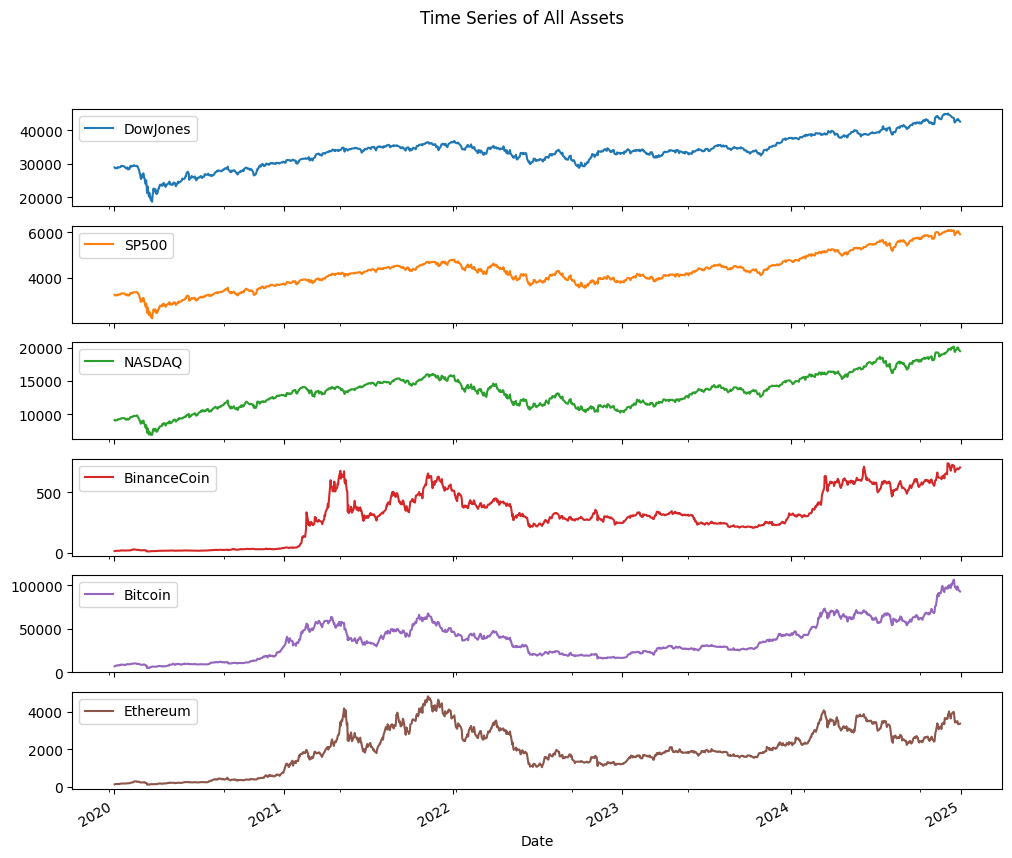

In [91]:
#outlier detection-visualization
merged_data.plot(subplots=True, figsize=(12, 10))
plt.suptitle('Time Series of All Assets')
plt.show()

In [92]:
#Stationarity Check

#ADF test on all columns
for col in merged_data.columns:
    result = adfuller(merged_data[col])
    print(f"{col}: ADF Statistic = {result[0]:.4f}, p-value = {result[1]:.4f}")

DowJones: ADF Statistic = -0.8266, p-value = 0.8112
SP500: ADF Statistic = -0.3038, p-value = 0.9250
NASDAQ: ADF Statistic = -0.5466, p-value = 0.8826
BinanceCoin: ADF Statistic = -1.4702, p-value = 0.5482
Bitcoin: ADF Statistic = -1.2252, p-value = 0.6627
Ethereum: ADF Statistic = -1.8855, p-value = 0.3389




*   p-value is greater than 0.05. Therefore, not stationary. Therefore, try again using the daily returns of each index and currency



In [93]:
#daily returns

returns_data = merged_data.pct_change().dropna()
print(returns_data.head())

            DowJones     SP500    NASDAQ  BinanceCoin   Bitcoin  Ethereum
Date                                                                     
2020-01-03 -0.008103 -0.007060 -0.007855     0.048625  0.051452  0.053069
2020-01-06  0.002392  0.003533  0.005620     0.094972  0.057773  0.075519
2020-01-07 -0.004170 -0.002803 -0.000319     0.003439  0.050774 -0.005268
2020-01-08  0.005647  0.004902  0.006689    -0.027071 -0.010269 -0.015924
2020-01-09  0.007369  0.006655  0.008127    -0.007164 -0.024851 -0.016133


In [94]:
#ADF test on all columns
for col in returns_data.columns:
    result = adfuller(returns_data[col])
    print(f"{col}: ADF Statistic = {result[0]:.4f}, p-value = {result[1]:.4f}")

DowJones: ADF Statistic = -10.8644, p-value = 0.0000
SP500: ADF Statistic = -10.7109, p-value = 0.0000
NASDAQ: ADF Statistic = -11.0509, p-value = 0.0000
BinanceCoin: ADF Statistic = -9.7781, p-value = 0.0000
Bitcoin: ADF Statistic = -12.6456, p-value = 0.0000
Ethereum: ADF Statistic = -12.8902, p-value = 0.0000




*   The daily returns dataset acheived p-values < 0.05 showing highly stationary behaviour. Therefore, it can be used from here forward.

CORRELATION ANALYSIS

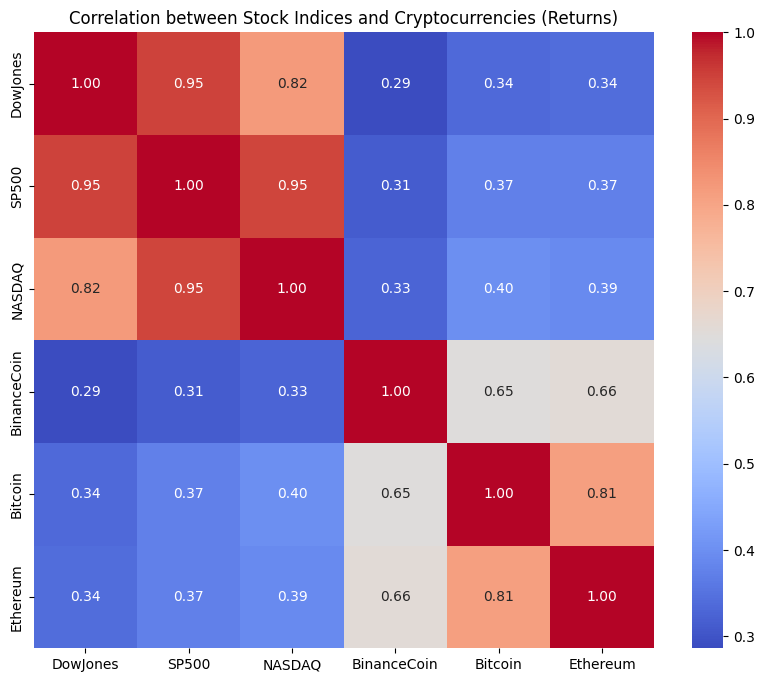

In [95]:
#Calculate correlation matrix
correlation_matrix = returns_data.corr()

#Plot a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Stock Indices and Cryptocurrencies (Returns)')
plt.show()



*   Strong correlation can be seen within the stock indices and within the cryptocurrencies separately. But there is only a weak correlation between the markets

GRANGER CAUSALITY

In [96]:
#Define your stock and crypto columns
stocks = ['DowJones', 'SP500', 'NASDAQ']
cryptos = ['Bitcoin', 'Ethereum', 'BinanceCoin']

#Maximum number of lags to test is set to 5
max_lag = 5

#Loop through all combinations
for stock in stocks:
    for crypto in cryptos:
        #Test: Does stock lead crypto?
        print(f"\nTesting if {stock} leads {crypto}")
        result = grangercausalitytests(returns_data[[crypto, stock]], maxlag=max_lag, verbose=False)

        #For each lag, print p-value
        for lag in range(1, max_lag + 1):
            p_value = result[lag][0]['ssr_ftest'][1]
            print(f"Lag {lag} p-value: {p_value:.4f}")

        #Test: Does crypto lead stock?
        print(f"\nTesting if {crypto} leads {stock}")
        result = grangercausalitytests(returns_data[[stock, crypto]], maxlag=max_lag, verbose=False)

        for lag in range(1, max_lag + 1):
            p_value = result[lag][0]['ssr_ftest'][1]
            print(f"Lag {lag} p-value: {p_value:.4f}")



Testing if DowJones leads Bitcoin
Lag 1 p-value: 0.2007
Lag 2 p-value: 0.4962
Lag 3 p-value: 0.5464
Lag 4 p-value: 0.5704
Lag 5 p-value: 0.4708

Testing if Bitcoin leads DowJones


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag 1 p-value: 0.3925
Lag 2 p-value: 0.0070
Lag 3 p-value: 0.0173
Lag 4 p-value: 0.0419
Lag 5 p-value: 0.0841

Testing if DowJones leads Ethereum
Lag 1 p-value: 0.4821
Lag 2 p-value: 0.3812
Lag 3 p-value: 0.5256
Lag 4 p-value: 0.5948
Lag 5 p-value: 0.3102

Testing if Ethereum leads DowJones
Lag 1 p-value: 0.9878
Lag 2 p-value: 0.0143
Lag 3 p-value: 0.0321
Lag 4 p-value: 0.0540
Lag 5 p-value: 0.0993

Testing if DowJones leads BinanceCoin
Lag 1 p-value: 0.1485
Lag 2 p-value: 0.1721
Lag 3 p-value: 0.2995
Lag 4 p-value: 0.3632
Lag 5 p-value: 0.4218

Testing if BinanceCoin leads DowJones
Lag 1 p-value: 0.4114
Lag 2 p-value: 0.0492
Lag 3 p-value: 0.0334
Lag 4 p-value: 0.0448
Lag 5 p-value: 0.0887

Testing if SP500 leads Bitcoin
Lag 1 p-value: 0.1728
Lag 2 p-value: 0.4533
Lag 3 p-value: 0.5416
Lag 4 p-value: 0.6092
Lag 5 p-value: 0.3256

Testing if Bitcoin leads SP500
Lag 1 p-value: 0.5136
Lag 2 p-value: 0.0429
Lag 3 p-value: 0.0969
Lag 4 p-value: 0.1787
Lag 5 p-value: 0.2912

Testing if SP50

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

Lag 1 p-value: 0.1285
Lag 2 p-value: 0.1717
Lag 3 p-value: 0.2851
Lag 4 p-value: 0.3771
Lag 5 p-value: 0.3418

Testing if BinanceCoin leads SP500
Lag 1 p-value: 0.2706
Lag 2 p-value: 0.1128
Lag 3 p-value: 0.0860
Lag 4 p-value: 0.1212
Lag 5 p-value: 0.2087

Testing if NASDAQ leads Bitcoin
Lag 1 p-value: 0.2688
Lag 2 p-value: 0.6064
Lag 3 p-value: 0.6374
Lag 4 p-value: 0.6750
Lag 5 p-value: 0.3026

Testing if Bitcoin leads NASDAQ
Lag 1 p-value: 0.3389
Lag 2 p-value: 0.0733
Lag 3 p-value: 0.1501
Lag 4 p-value: 0.2755
Lag 5 p-value: 0.3818

Testing if NASDAQ leads Ethereum


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag 1 p-value: 0.6221
Lag 2 p-value: 0.4631
Lag 3 p-value: 0.6560
Lag 4 p-value: 0.5452
Lag 5 p-value: 0.3165

Testing if Ethereum leads NASDAQ
Lag 1 p-value: 0.8707
Lag 2 p-value: 0.1703
Lag 3 p-value: 0.2593
Lag 4 p-value: 0.3871
Lag 5 p-value: 0.4880

Testing if NASDAQ leads BinanceCoin
Lag 1 p-value: 0.1353
Lag 2 p-value: 0.3123
Lag 3 p-value: 0.3749
Lag 4 p-value: 0.4742
Lag 5 p-value: 0.3830

Testing if BinanceCoin leads NASDAQ
Lag 1 p-value: 0.1261
Lag 2 p-value: 0.1079
Lag 3 p-value: 0.1277
Lag 4 p-value: 0.1795
Lag 5 p-value: 0.2476


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


* In most cases, p-values > 0.05 → no strong Granger causality.

* But a few interesting pairs DO show potential causality!

* Some cryptos seem to lead stock indices (especially DowJones and SP500) at short lags (2, 3, 4).
* All the three cryptos lead DowJones.
* Bitcoin leads SP500 at lag 2.
* Interesting because it’s the opposite of what many people assume (that stocks lead crypto!).

* No strong evidence that stocks are leading crypto here.


Selecting **Bitcoin** and **DowJones** to see if adding Bitcoin to the train the model would improve the accuracy of the model.

* The lag is chosen as 2 because of the lowest p-value

Feature Engineering

In [97]:
#Create lagged features
data = returns_data.copy()

#DowJones lags
data['DowJones_lag1'] = data['DowJones'].shift(1)
data['DowJones_lag2'] = data['DowJones'].shift(2)

#Bitcoin lags
data['Bitcoin_lag1'] = data['Bitcoin'].shift(1)
data['Bitcoin_lag2'] = data['Bitcoin'].shift(2)

#Target variable: DowJones return at time t
data['DowJones_target'] = data['DowJones']

#Drop rows with NaN values (because of shifting)
data = data.dropna()

print(data.head())

            DowJones     SP500    NASDAQ  BinanceCoin   Bitcoin  Ethereum  \
Date                                                                        
2020-01-07 -0.004170 -0.002803 -0.000319     0.003439  0.050774 -0.005268   
2020-01-08  0.005647  0.004902  0.006689    -0.027071 -0.010269 -0.015924   
2020-01-09  0.007369  0.006655  0.008127    -0.007164 -0.024851 -0.016133   
2020-01-10 -0.004598 -0.002855 -0.002670     0.036384  0.036487  0.035866   
2020-01-13  0.002889  0.006976  0.010357     0.013407 -0.002738  0.001826   

            DowJones_lag1  DowJones_lag2  Bitcoin_lag1  Bitcoin_lag2  \
Date                                                                   
2020-01-07       0.002392      -0.008103      0.057773      0.051452   
2020-01-08      -0.004170       0.002392      0.050774      0.057773   
2020-01-09       0.005647      -0.004170     -0.010269      0.050774   
2020-01-10       0.007369       0.005647     -0.024851     -0.010269   
2020-01-13      -0.004598   

In [98]:
#Baseline model: Only DowJones lags
baseline_features = data[['DowJones_lag1', 'DowJones_lag2']]

#Enhanced model: DowJones lags + Bitcoin lags
enhanced_features = data[['DowJones_lag1', 'DowJones_lag2', 'Bitcoin_lag1', 'Bitcoin_lag2']]

#Target variable
target = data['DowJones_target']

In [99]:
#Baseline split
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    baseline_features, target, test_size=0.2, shuffle=False)

#Enhanced split
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    enhanced_features, target, test_size=0.2, shuffle=False)


Linear Model

In [100]:
#Initialize linear regression model
lr = LinearRegression()

#Baseline Model (DowJones lags only)
#Train
lr.fit(X_train_base, y_train_base)

#Predict
y_pred_base = lr.predict(X_test_base)

#Evaluate
mse_base = mean_squared_error(y_test_base, y_pred_base)
mae_base = mean_absolute_error(y_test_base, y_pred_base)

print("Baseline Model (DowJones lags only):")
print(f"Mean Squared Error (MSE): {mse_base:.8f}")
print(f"Mean Absolute Error (MAE): {mae_base:.8f}")

#Enhanced Model (DowJones lags + Bitcoin lags)
#Train
lr.fit(X_train_enh, y_train_enh)

#Predict
y_pred_enh = lr.predict(X_test_enh)

#Evaluate
mse_enh = mean_squared_error(y_test_enh, y_pred_enh)
mae_enh = mean_absolute_error(y_test_enh, y_pred_enh)

print("\nEnhanced Model (DowJones + Bitcoin lags):")
print(f"Mean Squared Error (MSE): {mse_enh:.8f}")
print(f"Mean Absolute Error (MAE): {mae_enh:.8f}")


Baseline Model (DowJones lags only):
Mean Squared Error (MSE): 0.00005543
Mean Absolute Error (MAE): 0.00553151

Enhanced Model (DowJones + Bitcoin lags):
Mean Squared Error (MSE): 0.00005789
Mean Absolute Error (MAE): 0.00568561


The baseline model outperformed the enhanced model slightly showing that adding the Bitcoin prices did not significantly improve the prediction power

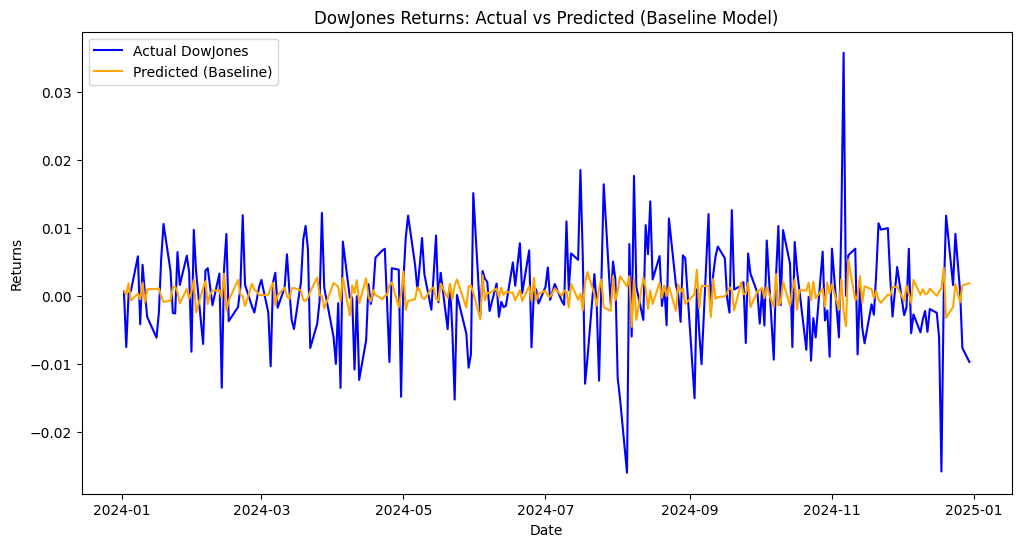

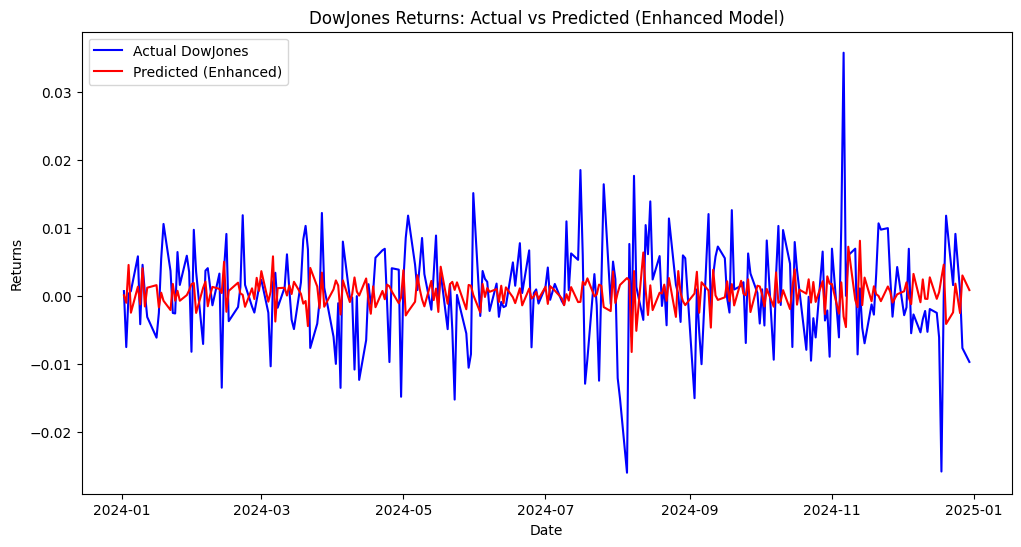

In [101]:
#Plot for Baseline model
plt.figure(figsize=(12, 6))
plt.plot(y_test_base.index, y_test_base, label='Actual DowJones', color='blue')
plt.plot(y_test_base.index, y_pred_base, label='Predicted (Baseline)', color='orange')
plt.title('DowJones Returns: Actual vs Predicted (Baseline Model)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

#Plot for Enhanced model
plt.figure(figsize=(12, 6))
plt.plot(y_test_enh.index, y_test_enh, label='Actual DowJones', color='blue')
plt.plot(y_test_enh.index, y_pred_enh, label='Predicted (Enhanced)', color='red')
plt.title('DowJones Returns: Actual vs Predicted (Enhanced Model)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()


It can be seen that the difference in performance is very small for the baseline and advanced models

Non-linear model: RandomForest

In [102]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Initialize linear regression model
rf = RandomForestRegressor()

#Baseline Model (DowJones lags only)
#Train
rf.fit(X_train_base, y_train_base)

#Predict
y_pred_base = rf.predict(X_test_base)

#Evaluate
mse_base = mean_squared_error(y_test_base, y_pred_base)
mae_base = mean_absolute_error(y_test_base, y_pred_base)

print("Baseline Model (DowJones lags only):")
print(f"Mean Squared Error (MSE): {mse_base:.8f}")
print(f"Mean Absolute Error (MAE): {mae_base:.8f}")

#Enhanced Model (DowJones lags + Bitcoin lags)
#Train
rf.fit(X_train_enh, y_train_enh)

#Predict
y_pred_enh = rf.predict(X_test_enh)

#Evaluate
mse_enh = mean_squared_error(y_test_enh, y_pred_enh)
mae_enh = mean_absolute_error(y_test_enh, y_pred_enh)

print("\nEnhanced Model (DowJones + Bitcoin lags):")
print(f"Mean Squared Error (MSE): {mse_enh:.8f}")
print(f"Mean Absolute Error (MAE): {mae_enh:.8f}")


Baseline Model (DowJones lags only):
Mean Squared Error (MSE): 0.00007247
Mean Absolute Error (MAE): 0.00649730

Enhanced Model (DowJones + Bitcoin lags):
Mean Squared Error (MSE): 0.00006646
Mean Absolute Error (MAE): 0.00610666


In the RandomForest model, the result is opposite. While the model as a whole doesn't outperform the linear model, the RF model trained with the advanced features including the Bitcoin prices outperforms the baseline RF model

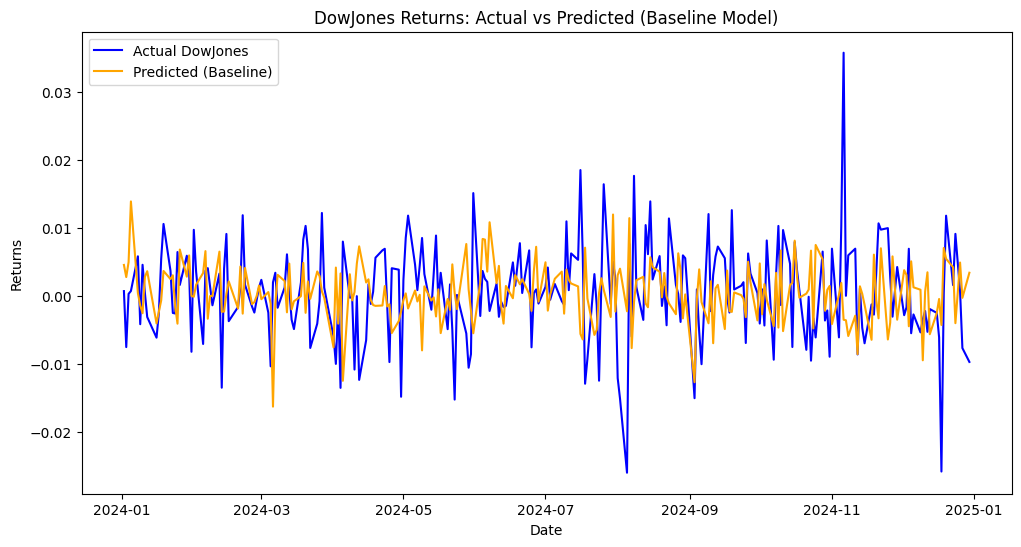

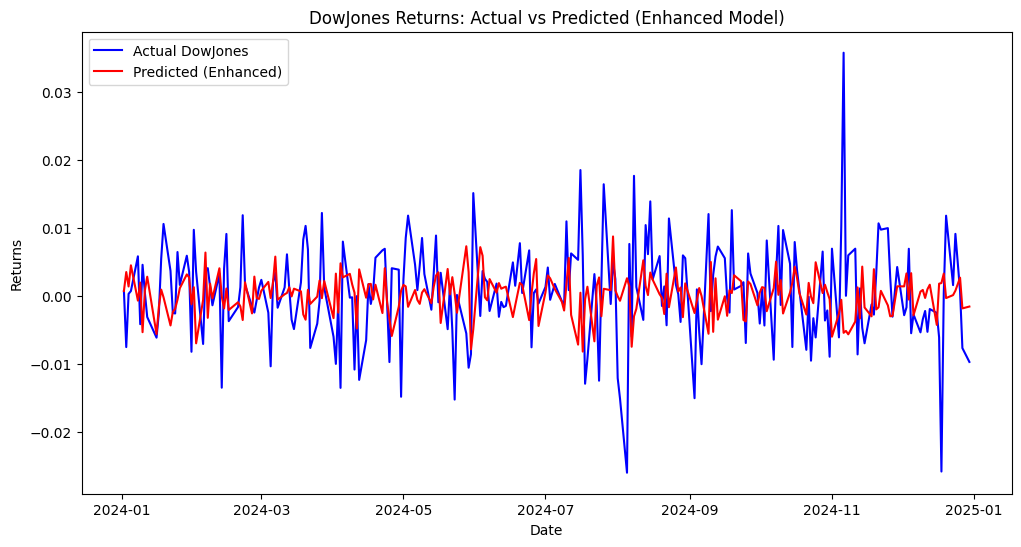

In [103]:
#Plot for Baseline model
plt.figure(figsize=(12, 6))
plt.plot(y_test_base.index, y_test_base, label='Actual DowJones', color='blue')
plt.plot(y_test_base.index, y_pred_base, label='Predicted (Baseline)', color='orange')
plt.title('DowJones Returns: Actual vs Predicted (Baseline Model)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

#Plot for Enhanced model
plt.figure(figsize=(12, 6))
plt.plot(y_test_enh.index, y_test_enh, label='Actual DowJones', color='blue')
plt.plot(y_test_enh.index, y_pred_enh, label='Predicted (Enhanced)', color='red')
plt.title('DowJones Returns: Actual vs Predicted (Enhanced Model)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()


Even so, the difference in the performance is still marginal between the baseline and advanced models

# Conclusion


In this project, we explored the relationship between major stock indices (DowJones, SP500, NASDAQ) and cryptocurrencies (Bitcoin, Ethereum, BinanceCoin) from 2019 to 2024.

We carried out:
- **Correlation analysis**, which showed that while stock indices are strongly correlated with each other, their correlation with cryptocurrencies is moderate to low.
- **Granger causality tests**, which indicated that some cryptocurrencies (like Bitcoin and BinanceCoin) Granger-cause DowJones returns at short lags (especially lag 2).
- **Predictive modeling**, where we compared:
  - A **baseline model** (using only past DowJones returns),
  - An **enhanced model** (using past DowJones + Bitcoin returns),
  - Using both **Linear Regression** and **Random Forest Regressor**.

**Key Findings:**
- **Linear Regression** achieved the best performance overall, and adding Bitcoin returns did not significantly improve prediction.
- **Random Forest** showed slight improvement when Bitcoin returns were included, suggesting possible non-linear relationships, but still underperformed compared to Linear Regression.

**Final Insight:**
> While statistical relationships between crypto and stock indices exist at short lags, their practical impact on improving return predictions remains limited under simple modeling approaches.

This project highlights the importance of careful testing, model comparison, and honest evaluation in financial time-series analysis.

